In [1]:
%load_ext autoreload
%autoreload 2

import tracemalloc
from collections import Counter
import linecache
import os

def display_top(snapshot, key_type='lineno', limit=3):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    top_stats = snapshot.statistics(key_type)

    print("Top %s lines" % limit)
    for index, stat in enumerate(top_stats[:limit], 1):
        frame = stat.traceback[0]
        # replace "/path/to/module/file.py" with "module/file.py"
        filename = os.sep.join(frame.filename.split(os.sep)[-2:])
        print("#%s: %s:%s: %.1f KiB"
              % (index, filename, frame.lineno, stat.size / 1024))
        line = linecache.getline(frame.filename, frame.lineno).strip()
        if line:
            print('    %s' % line)

    other = top_stats[limit:]
    if other:
        size = sum(stat.size for stat in other)
        print("%s other: %.1f KiB" % (len(other), size / 1024))
    total = sum(stat.size for stat in top_stats)
    print("Total allocated size: %.1f KiB" % (total / 1024))

tracemalloc.start()


In [2]:
from utils_v1 import *


In [3]:
from icecream import ic

import numpy as np
from src.dataset import (
    MultipleDates, PAMultipleDates,
    MTMultipleDates
)

from src import training_generator as generator
from src.patchesHandler import PatchesHandler, PatchesHandlerMultipleDates, PatchesHandlerEvidential

from src.manager.evidential import ManagerEvidential, ManagerEvidentialUEO
import src.manager.evidential as evidential

from mpl_toolkits.axes_grid1 import make_axes_locatable

import cv2
from src import metrics as _metric
from src.Logger import Logger


Tensorflow ver. 2.6.0


In [4]:

config = {
	"training": True,
	"learning_rate": 1e-4, # 1e-3
	"weights": [0.1, 0.9, 0],
	"save_probabilities": False,
	"loadInference": False,
	"addPastDeforestationInput": True,
	"inference_times": 1,
	"Uncertainty": {
		"annealing_step": 10*375 # 1875, 10*375*10
	},
	"uncertainty_method": "evidential",
	"evidence_function": evidential.relu_evidence,
	"site": "PA",
	"training_date": "current", # values: earlier, current
	"use_cloud_mask": True
}

# config["loss"] = config["loss"](config["weights"])
'''
if config["training"] == True:
	dates = [2017, 2018]
else:
	dates = [2018, 2019]
if config["training"] == True:
	dates = [2018, 2019]
else:
	dates = [2019, 2020]
'''
if config['site'] == 'PA':
	if config['training'] == True and config['training_date'] == 'earlier':
		dates = [2017, 2018]
	else:
		dates = [2018, 2019]

	dataset = PAMultipleDates(config = config, 
		dates = dates, 
		addPastDeforestationInput = config['addPastDeforestationInput'],
		borderBuffer = 2)	
elif config['site'] == 'MT':
	if config['training'] == True and config['training_date'] == 'earlier':
		dates = [2018, 2019]
	else:
		dates = [2019, 2020]

	dataset = MTMultipleDates(config = config, 
		dates = dates, # dates = [2016,2017,2018,2019]
		addPastDeforestationInput = config['addPastDeforestationInput'],
		borderBuffer = 2)	

ic(dates)


if issubclass(type(dataset), MultipleDates):
	patchesHandler = PatchesHandlerEvidential(
		dataset)
else:
	patchesHandler = PatchesHandler()


if config['training'] == False:

	if type(dataset) == PAMultipleDates:


		if config['training_date'] == 'current': exp = 4; repetition_id = 0
		elif config['training_date'] == 'earlier': exp = 6; repetition_id = 0
		 
	if type(dataset) == MTMultipleDates:
		
		if config['training_date'] == 'current': exp = 7; repetition_id = 0
		elif config['training_date'] == 'earlier': exp = 8; repetition_id = 0		

		
else:

	exp = 10


logger = Logger()
manager = ManagerEvidential(config, dataset, patchesHandler, logger)

manager.defineExperiment(exp)


ic| list(self.date_ids): [0]
ic| self.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]
ic| dates: [2018, 2019]
ic| self.input_image_shape: 21
ic| self.dataset.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]


In [5]:
exp

10

In [6]:
manager.setExperimentPath()
manager.createLogFolders()

In [7]:
# ic(type(dataset), exp, dataset.dates)


In [8]:

manager.loadLabel()

D:/Jorge/datasets/deforestation/PA/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2019) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/PA/deforestation_before_2008_PA.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([124211220,  38957970], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))
ic| label_per_date.shape: (17730, 9203, 1)


Removing bufer................
Mask label shape:  
 (17730, 9203, 1) 
 Unique values:  
 [0 1 2]


In [9]:

# Creating tile mask
manager.createTrainValTestTiles()


Tiles size:  3546 2300
Mask size:  (17730, 9200)


In [10]:

manager.label_mask.dtype

dtype('uint8')

In [11]:

manager.getLabelCurrentDeforestation()

In [12]:

manager.loadInputImage()

ic| image_stack.shape: (17730, 9203, 21)


Image shape:  (17730, 9203, 21)
mask:  (17730, 9200)
image stack:  (17730, 9200, 21)
ref : (17730, 9200, 1)


In [13]:

np.unique(manager.image_stack[...,0], return_counts=True)

(array([0.        , 0.08333334, 0.16666667, 0.25      , 0.33333334,
        0.4166667 , 0.5       , 0.5833334 , 0.6666667 , 0.75      ,
        0.8333334 , 0.9166667 , 1.        ], dtype=float32),
 array([104050616,   2209014,    644713,    968315,   1458862,   1560879,
          2477424,   1299508,    903419,    864429,   4570932,   3150455,
         38957434], dtype=int64))

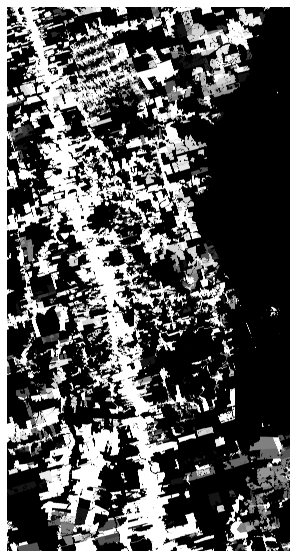

In [14]:

manager.logger.plotFigure(manager.image_stack[...,0], 
    name='image_stack_first_channel', cmap=plt.cm.gray, savefig=False)

In [15]:

manager.getImageChannels()

ic| self.image_stack.shape: (17730, 9200, 21)
ic| self.channels: 21


In [16]:

manager.getTrainValTestMasks()

Training tiles:  [1, 3, 5, 8, 11, 13, 14, 20]
Validation tiles:  [6, 19]
Test tiles:  [2, 4, 7, 9, 10, 12, 15, 16, 17, 18]


In [17]:

if config["training"] == True:
    # Extracting patches from the idx matrix
    manager.createIdxImage()


ic| im_idx_row.shape: (17730, 9200, 1)
    im_idx_col.shape: (17730, 9200, 1)
ic| im_idx_row.dtype: dtype('uint16')
    im_idx_col.dtype: dtype('uint16')
ic| im_idx.shape: (17730, 9200, 2), im_idx.dtype: dtype('uint16')


In [18]:
if config["training"] == True:
    manager.extractCoords()

ic| coords.shape: (464, 239, 1, 128, 128, 2)
    coords.dtype: dtype('uint16')
ic| coords.shape: (110896, 2), coords.dtype: dtype('uint16')


In [19]:
if config["training"] == True:
    manager.trainTestSplit()

ic| self.coords_train.shape: (41812, 3)
    self.coords_val.shape: (10260, 3)


In [20]:
if config["training"] == True:
    manager.label_mask.shape

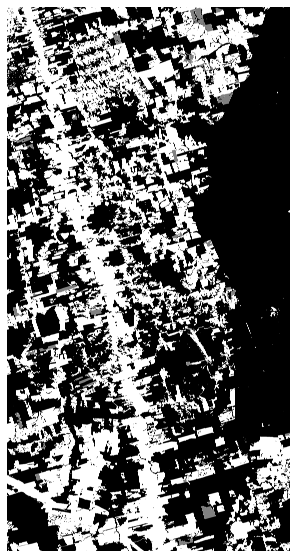

In [21]:
if config["training"] == True:

    manager.logger.plotFigure(manager.label_mask[...,-1], 
        name='Reference', cmap=plt.cm.gray, savefig=False)



In [22]:
if config["training"] == True:
    np.unique(manager.label_mask)

In [23]:
if config["training"] == True:
    print(manager.coords_train)

[[    0     0     0]
 [    0    38     0]
 [    0    76     0]
 ...
 [17594  8968     0]
 [17594  9006     0]
 [17594  9044     0]]


In [24]:
if config["training"] == True:
    manager.retrieveSamplesOfInterest()

training samples:  (3753, 3) validation samples:  (1032, 3)


In [25]:
if config["training"] == True:
    inputSnipShow = True

[12084  2508     0]
coord [12084  2508     0]
image_patch.shape (17730, 9200, 1)
reference_patch.shape (17730, 9200, 21)


ic| np.mean(image_patch[...,dataset.previewBandsSnip[0]]): 0.107682176
    np.mean(image_patch[...,dataset.previewBandsSnip[1]]): 0.22637562


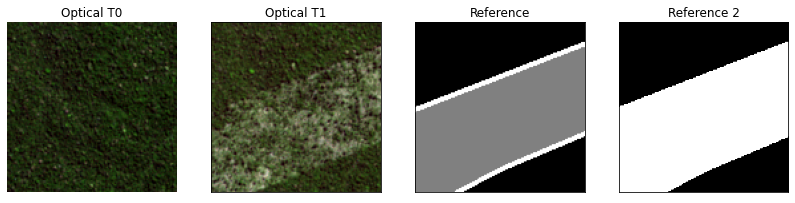

In [26]:
if config["training"] == True:
    if inputSnipShow == True:
        manager.snipDataset(idx = 2800)


ic| np.mean(image_patch[...,dataset.previewBandsSnip[0]]): 0.2714837
    np.mean(image_patch[...,dataset.previewBandsSnip[1]]): 0.30292988
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 114 5928    0]
coord [ 114 5928    0]
image_patch.shape (17730, 9200, 1)
reference_patch.shape (17730, 9200, 21)


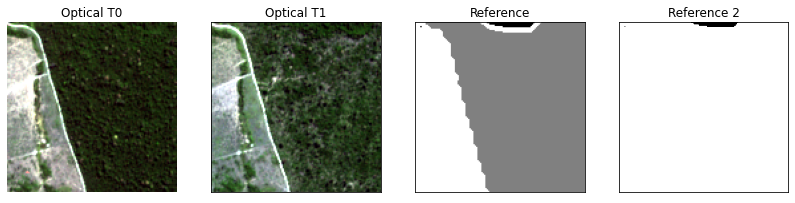

In [27]:
if config["training"] == True:
    if inputSnipShow == True:
        manager.snipDataset(idx = 97)


ic| np.mean(image_patch[...,dataset.previewBandsSnip[0]]): 0.15096879
    np.mean(image_patch[...,dataset.previewBandsSnip[1]]): 0.103304155


[3382 2128    0]
coord [3382 2128    0]
image_patch.shape (17730, 9200, 1)
reference_patch.shape (17730, 9200, 21)


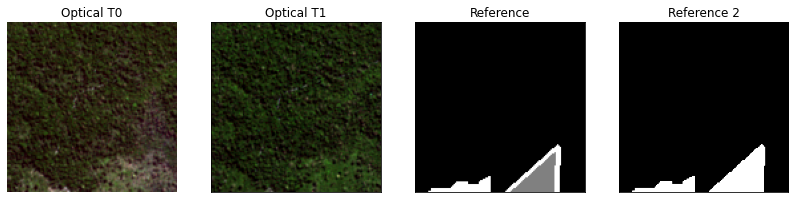

In [28]:
if config["training"] == True:
    if inputSnipShow == True:

        manager.snipDataset(idx = 1200)

ic| np.mean(image_patch[...,dataset.previewBandsSnip[0]]): 0.09604081
    np.mean(image_patch[...,dataset.previewBandsSnip[1]]): 0.23388559


[ 608 6574    0]
coord [ 608 6574    0]
image_patch.shape (17730, 9200, 1)
reference_patch.shape (17730, 9200, 21)


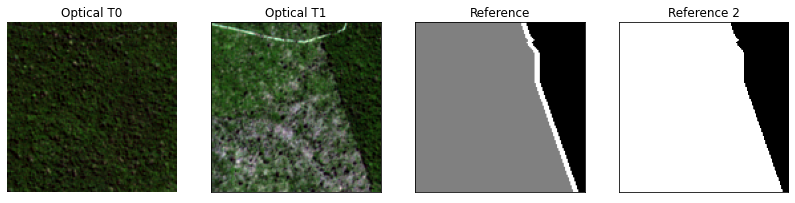

In [29]:
if config["training"] == True:
    if inputSnipShow == True:

        manager.snipDataset(idx = 400)

In [30]:
if config["training"] == True:
    manager.getGenerators()


In [31]:
if config["training"] == True:
    manager.fixChannelNumber()

In [32]:
if config["training"] == True:
    print(manager.path_exp)

D:/Jorge/datasets/deforestation/experiments/PA/exp10


In [33]:
if config["training"] == True:
    print(manager.channels)

21


In [34]:
if config["training"] == True:
    print(manager.image_stack.shape)

(17730, 9200, 21)


In [35]:
# manager.weights = [0.01, 0.99, 0]
manager.weights

[0.1, 0.9, 0]

### Evidential metrics

In [36]:
if config["training"] == True:
    manager.train()

time:  0


c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_enc_net (InputLayer)      [(None, 128, 128, 21 0                                            
__________________________________________________________________________________________________
res1_net1 (Conv2D)              (None, 128, 128, 16) 3040        input_enc_net[0][0]              
__________________________________________________________________________________________________
drop_net1 (Dropout)             (None, 128, 128, 16) 0           res1_net1[0][0]                  
__________________________________________________________________________________________________
res2_net1 (Conv2D)              (None, 128, 128, 16) 2320        drop_net1[0][0]                  
______________________________________________________________________________________________

c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\keras\engine\training.py:1969: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


alpha Tensor("loss/add:0", shape=(None, 128, 128, 3), dtype=float32)
u Tensor("loss/truediv:0", shape=(None, 128, 128, 1), dtype=float32)
A Tensor("loss/Sum_3:0", shape=(None, 3), dtype=float32)
B Tensor("loss/Sum_4:0", shape=(None, 1, 1, 3), dtype=float32)
term1 Tensor("loss/truediv_7:0", shape=(None, 1, 1, 3), dtype=float32)
term2 Tensor("loss/mul_5:0", shape=(None, 1, 1, 3), dtype=float32)
Tensor("loss/Repeat_1/Reshape_1:0", shape=(None, None, None, 1), dtype=float32)
alpha Tensor("add:0", shape=(None, 128, 128, 3), dtype=float32)
u Tensor("truediv:0", shape=(None, 128, 128, 1), dtype=float32)
K.int_shape(KL_reg) Tensor("mul_6:0", shape=(None, 128, 128, 1), dtype=float32)
alpha Tensor("add_7:0", shape=(None, 128, 128, 3), dtype=float32)
u Tensor("truediv_5:0", shape=(None, 128, 128, 1), dtype=float32)
K.int_shape(KL_reg) Tensor("mul_12:0", shape=(None, 128, 128, 1), dtype=float32)
alpha Tensor("add_16:0", shape=(None, 128, 128, 3), dtype=float32)
u Tensor("truediv_13:0", shape=(None

c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/100
self.global_step 350.0
131/351 [==========>...................] - ETA: 16s - loss: 0.7927 - accuracy: 0.8790 - KL_term: 0.0092 - loglikelihood_term: 0.2011 - evidential_success: 33.9643 - evidential_fail: 11.0172 - acc: 0.8793 - annealing_coef: 0.0347 - global_step_get: 130.0000 - annealing_step_get: 3750.0000 - UEO_term: 0.3127

143/351 [===========>..................] - ETA: 15s - loss: 0.7929 - accuracy: 0.8805 - KL_term: 0.0097 - loglikelihood_term: 0.1989 - evidential_success: 33.8679 - evidential_fail: 10.8196 - acc: 0.8807 - annealing_coef: 0.0379 - global_step_get: 142.0000 - annealing_step_get: 3750.0000 - UEO_term: 0.3153

In [ ]:
if config["training"] == True:
    manager.plotHistory()


In [ ]:
if config["training"] == True:
    manager.plotLossTerms()

In [ ]:
if config["training"] == True:
    manager.plotAnnealingCoef()

In [ ]:
def draw_EDL_results(K, history):
    # train_acc1, train_ev_s, train_ev_f, test_acc1, test_ev_s, test_ev_f 
    # calculate uncertainty for training and testing data for correctly and misclassified samples
    '''
    K: known classes
    '''
    train_u_succ = K / (K+np.array(history['evidential_success']))
    train_u_fail = K / (K+np.array(history['evidential_fail']))
    test_u_succ  = K / (K+np.array(history['val_evidential_success']))
    test_u_fail  = K / (K+np.array(history['val_evidential_fail']))
    
    f, axs = plt.subplots(2, 2)
    f.set_size_inches([10,10])
    
    axs[0,0].plot(history['evidential_success'],c='r',marker='+')
    axs[0,0].plot(history['evidential_fail'],c='k',marker='x')
    axs[0,0].set_title('Train Data')
    axs[0,0].set_xlabel('Epoch')
    axs[0,0].set_ylabel('Estimated total evidence for classification') 
    axs[0,0].legend(['Correct Clasifications','Misclasifications'])
    
    axs[0,1].plot(train_u_succ,c='r',marker='+')
    axs[0,1].plot(train_u_fail,c='k',marker='x')
    axs[0,1].plot(history['acc'],c='blue',marker='*')
    axs[0,1].set_title('Train Data')
    axs[0,1].set_xlabel('Epoch')
    axs[0,1].set_ylabel('Estimated uncertainty for classification')
    axs[0,1].legend(['Correct clasifications','Misclasifications', 'Accuracy'])
    
    axs[1,0].plot(history['val_evidential_success'],c='r',marker='+')
    axs[1,0].plot(history['val_evidential_fail'],c='k',marker='x')
    axs[1,0].set_title('Test Data')
    axs[1,0].set_xlabel('Epoch')
    axs[1,0].set_ylabel('Estimated total evidence for classification') 
    axs[1,0].legend(['Correct Clasifications','Misclasifications'])
    
    axs[1,1].plot(test_u_succ,c='r',marker='+')
    axs[1,1].plot(test_u_fail,c='k',marker='x')
    axs[1,1].plot(history['val_acc'],c='blue',marker='*')
    axs[1,1].set_title('Test Data')
    axs[1,1].set_xlabel('Epoch')
    axs[1,1].set_ylabel('Estimated uncertainty for classification')
    axs[1,1].legend(['Correct clasifications','Misclasifications', 'Accuracy'])
    

In [ ]:
if config["training"] == True:
    draw_EDL_results(manager.class_n, manager.history.history)

    plt.figure(5)
    plt.plot(manager.history.history['evidential_success'],c='r',marker='+')
    plt.plot(manager.history.history['evidential_fail'],c='k',marker='x')
    plt.title('Train Data')
    plt.xlabel('Epoch')
    plt.ylabel('Estimated total evidence for classification') 
    plt.legend(['Correct Clasifications','Misclasifications'])


In [ ]:
manager.image_stack.shape

(17730, 9200, 21)

In [ ]:
manager.patchesHandler.dataset.image_channels[-1]

In [ ]:
if issubclass(type(dataset), MultipleDates):
	manager.channels = manager.patchesHandler.input_image_shape
	manager.image_stack = manager.image_stack[..., manager.patchesHandler.dataset.image_channels[-1]]
	manager.label_mask = manager.label_mask[...,-1]

In [ ]:
manager.image_stack.shape

(17730, 9200, 21)

In [ ]:
manager.setPadding()

-30.0 -16.0


In [ ]:
manager.infer()

ic| self.path_models+ '/' + self.method +'_'+str(0)+'.h5': 'D:/Jorge/datasets/deforestation/experiments/exp195/models/resunet_0.h5'


time:  0


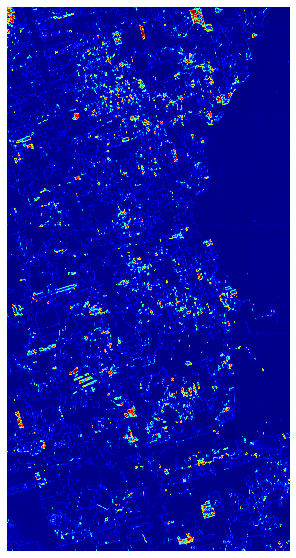

In [ ]:
manager.logger.plotFigure(manager.u_reconstructed, 
            name='Uncertainty', cmap='jet', savefig=False, figsize=(10,10))

In [ ]:
manager.loadPredictedProbabilities()


In [ ]:
manager.prob_rec.shape

(17760, 9216)

In [ ]:
manager.getMeanProb()

In [ ]:
manager.logger.getStats(manager.mean_prob)

ic| np.min(value): 0.002648883
    np.mean(value): 0.02701553
    np.max(value): 0.9709198


In [ ]:
ic(manager.mean_prob.shape)

ic| trainer.mean_prob.shape: (17760, 9216)


(17760, 9216)

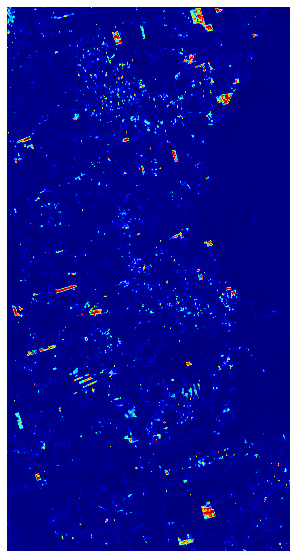

In [ ]:
manager.unpadMeanProb()
manager.logger.plotFigure(manager.mean_prob, 
            name='Mean predicted probability', figsize=(10,10), cmap='jet', savefig=False)

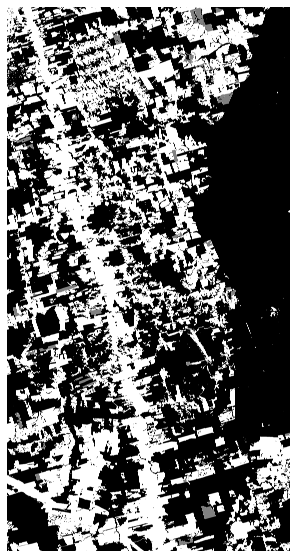

In [ ]:
manager.logger.plotFigure(manager.label_mask, 
            name='Reference mask', figsize=(10,10), cmap=plt.cm.gray, savefig=True)

In [ ]:
manager.squeezeLabel()

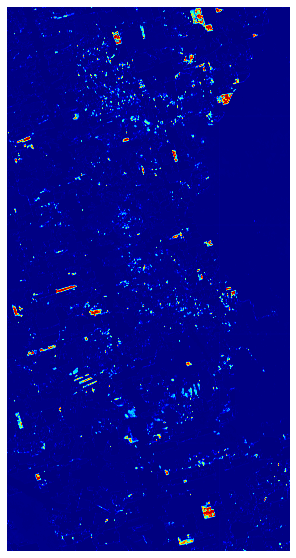

In [ ]:
manager.setMeanProbNotConsideredAreas()
manager.logger.plotFigure(manager.mean_prob, 
            name='Mean predicted probability', figsize=(10,10), cmap='jet', savefig=False)

In [ ]:
manager.logger.getStats(manager.mean_prob)

ic| np.min(value): 0.0
    np.mean(value): 0.020939866
    np.max(value): 0.9709198


In [ ]:
print(manager.label_mask.shape)

(17730, 9200)


In [ ]:
manager.getLabelTest()

(54236371,)
(array([0, 1], dtype=uint8), array([53470765,   765606], dtype=int64))


In [ ]:
manager.getMAP()

82.17


In [ ]:
manager.prob_rec.shape

(17760, 9216)

In [ ]:
manager.preprocessProbRec()
print(manager.prob_rec.shape)

(17760, 9216, 1)


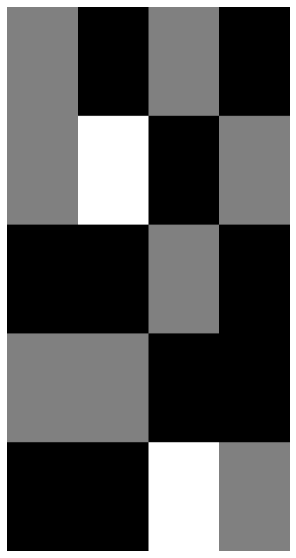

In [ ]:
manager.logger.plotFigure(manager.mask_tr_val, 
            name=manager.dataset.site + manager.title_name + ' Train val mask.png', figsize=(10,10), savefig=False)

In [ ]:
manager.getLabelCurrentDeforestation()

In [ ]:
manager.applyProbabilityThreshold()

(17730, 9200)
(array([0., 1.], dtype=float32), array([161465114,   1650886], dtype=int64))


ic| self.predicted_unpad.shape: (17730, 9200)
    self.predicted.shape: (17730, 9200)


In [ ]:
manager.getTestValues()

ic| predicted_test.shape: (81558000,)
ic| predicted_test.shape: (54236371,)


In [ ]:
manager.removeSmallPolygons()

ic| np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([161465114,   1650886], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([161736422,   1379578], dtype=int64))
ic| np.unique(ignored_polygons, return_counts=True): (array([0., 1.], dtype=float32), array([162844692,    271308], dtype=int64))


In [ ]:
manager.calculateMetrics()

ic| self.f1: 78.78, self.precision: 88.6, self.recall: 70.91


In [ ]:
manager.getValidationValuesForMetrics()
manager.calculateMetricsValidation()

ic| self.label_mask_val.shape: (16311600,)
ic| self.label_mask_val_valid.shape: (9418680,)
ic| f1_val: 78.96
    precision_val: 87.89
    recall_val: 71.68
    mAP_val: 86.7


In [ ]:
calculateMAPWithoutSmallPolygons = False
if calculateMAPWithoutSmallPolygons == True:
    manager.calculateMAPWithoutSmallPolygons()

In [ ]:
manager.get_label_no_buffer()


D:/Jorge/datasets/deforestation/Para/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2019) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/deforestation_before_2008/deforestation_before_2008_para.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([124211220,  38957970], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))
ic| label_per_date.shape: (17730, 9203, 1)


In [ ]:
manager.getErrorMask()

(array([0., 1.], dtype=float32), array([162316504,    799496], dtype=int64))


In [ ]:
'''

import types

manager.getErrorMaskToShowRGB = types.MethodType(getErrorMaskToShowRGB, manager)
'''


'\n\nimport types\n\ntrainer.getErrorMaskToShowRGB = types.MethodType(getErrorMaskToShowRGB, trainer)\n'

In [ ]:
manager.getErrorMaskToShowRGB()

[0. 1.]


In [ ]:
predicted_unpad_to_show = manager.predicted_unpad.copy()

predicted_unpad_to_show[manager.label_mask == 2] = 0
print(np.unique(predicted_unpad_to_show))

[0. 1.]


In [ ]:
predicted_unpad_to_show.shape

(17730, 9200)

In [ ]:

'''
manager.logger.plotFigure = types.MethodType(manager.logger.plotFigure, manager)
'''

'\ntrainer.logger.plotFigure = types.MethodType(trainer.logger.plotFigure, trainer)\n'

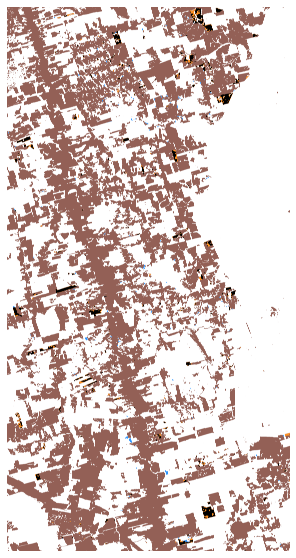

In [ ]:
manager.logger.plotFigure(manager.error_mask_to_show_rgb[...,::-1], 
            name=manager.dataset.site + manager.title_name + ' error mask color.png', 
            figsize=(10,10), savefig=True, dpi=300)

In [ ]:
manager.setUncertainty()

In [ ]:
manager.getValidationValues2()
manager.getTestValues2()

ic| self.label_mask.shape: (17730, 9200)
ic| self.mask_amazon_ts.shape: (17730, 9200)
ic| self.label_mask_test.shape: (81558000,)
ic| self.error_mask_test.shape: (54102424,)


In [ ]:
manager.getUncertaintyToShow()
manager.logger.getStats(manager.uncertainty_to_show)


ic| np.min(value): 0.0, np.mean(value): 0.04063242, np.max(value): 1.0


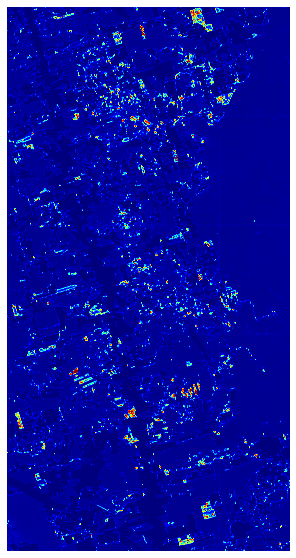

In [ ]:
manager.logger.plotFigure(manager.uncertainty_to_show, 
            name=manager.dataset.site + manager.title_name + ' uncertainty evidential learning.png', figsize=(10,10), cmap='jet', savefig=True)

ic| trainer.dataset.previewLims1: array([2200, 3200, 6900, 7900])
    trainer.dataset.previewLims2: array([ 500, 1500, 3500, 4500])
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([1000000], dtype=int64))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


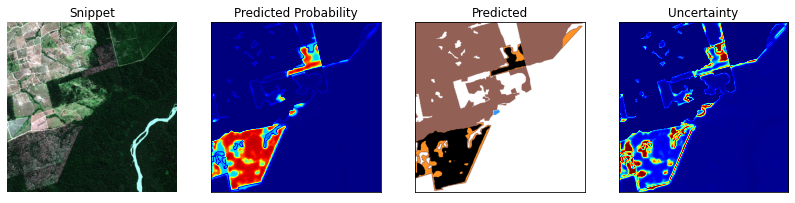

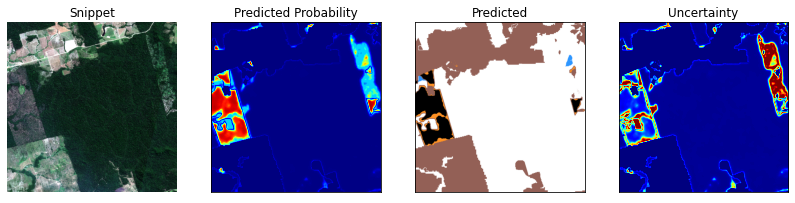

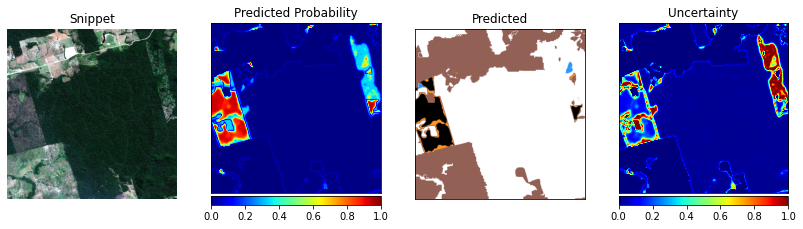

In [ ]:
manager.logger.plotCropSample(manager)

In [ ]:
manager.logger.getStats(manager.uncertainty)

ic| np.min(value): 0.00794665
    np.mean(value): 0.057781108
    np.max(value): 1.0


In [ ]:
get_other_uncertainty_metrics = True
if get_other_uncertainty_metrics == True:
    manager.getOtherUncertaintyMetrics()
    print(manager.sUEO)

    print(manager.ece_score)  

(54102424,) (54102424,)
0.4216257755386668
ECE. Starting bin 0...
ECE. Starting bin 1...
ECE. Starting bin 2...
ECE. Starting bin 3...
ECE. Starting bin 4...
ECE. Starting bin 5...
ECE. Starting bin 6...
ECE. Starting bin 7...
ECE. Starting bin 8...
ECE. Starting bin 9...
0.048271416877271794
0.4216257755386668
0.048271416877271794


In [ ]:
# manager.getUncertaintyMetrics()

In [ ]:
# manager.m

In [ ]:
print(manager.uncertainty.shape, manager.predicted_test.shape)
print(manager.uncertainty.dtype, manager.predicted_test.dtype)
print(np.unique(manager.predicted_test))
print(manager.label_mask_current_deforestation_test.shape)


(54102424,) (54102424,)
float32 float32
[0. 1.]
(54102424,)


In [ ]:
manager.mean_prob[manager.mask_amazon_ts == 1].shape

(81558000,)

In [ ]:
uncertainty_test_correct = manager.uncertainty[manager.predicted_test == manager.label_mask_current_deforestation_test]
uncertainty_test_incorrect = manager.uncertainty[manager.predicted_test != manager.label_mask_current_deforestation_test]

predicted_test_correct = manager.uncertainty[manager.predicted_test == manager.label_mask_current_deforestation_test]
uncertainty_test_incorrect = manager.uncertainty[manager.predicted_test != manager.label_mask_current_deforestation_test]


In [ ]:
print(np.min(uncertainty_test_correct), np.mean(uncertainty_test_correct), np.max(uncertainty_test_correct))
print(np.min(uncertainty_test_incorrect), np.mean(uncertainty_test_incorrect), np.max(uncertainty_test_incorrect))


0.00794665 0.054352395 1.0
0.01722374 0.71877086 1.0


In [ ]:
manager.alpha_reconstructed.shape

(17760, 9216, 3)

In [ ]:
manager.alpha_unpad = manager.alpha_reconstructed[:manager.label_mask.shape[0], :manager.label_mask.shape[1]]

In [ ]:
manager.alpha_unpad.shape

(17730, 9200, 3)

In [ ]:
print(np.min(manager.alpha_unpad), np.mean(manager.alpha_unpad), np.max(manager.alpha_unpad))

1.0 40.11602 375.5176


In [ ]:
manager.predicted_unpad.shape

(17730, 9200)

In [ ]:
manager.label_mask.shape

(17730, 9200)

In [ ]:
'''
fig = plt.figure(figsize=(20,20))


plt.imshow(manager.alpha_unpad.astype(np.uint8))
plt.plot(6600, 16500, marker='v', color="white")
plt.plot(5600, 16500, marker='v', color="white")
plt.plot(4600, 16500, marker='v', color="white")
'''

'\nfig = plt.figure(figsize=(20,20))\n\n\nplt.imshow(trainer.alpha_unpad.astype(np.uint8))\nplt.plot(6600, 16500, marker=\'v\', color="white")\nplt.plot(5600, 16500, marker=\'v\', color="white")\nplt.plot(4600, 16500, marker=\'v\', color="white")\n'

(17730, 9200)
[[550, 115], [430, 950]]


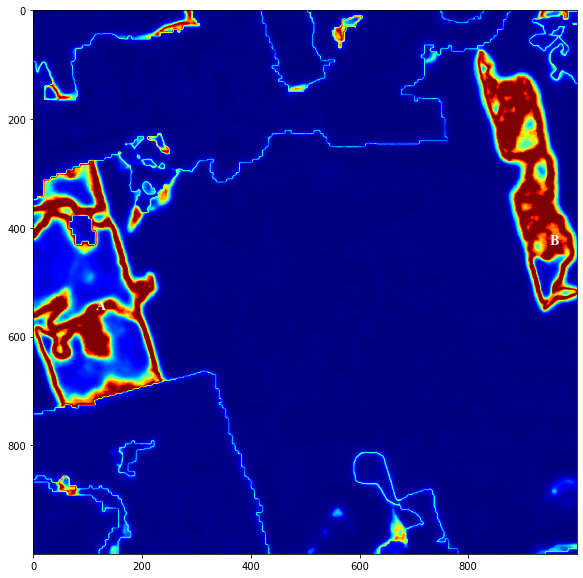

In [ ]:
print(manager.mean_prob.shape)

lims = dataset.previewLims2
im = manager.uncertainty_map[lims[0]:lims[1], lims[2]:lims[3]]
plt.figure(figsize=(10,10))
plt.imshow(im, cmap='jet')
font = {'family': "Times New Roman",
        'color':  'white',
        'weight': 'bold',
        'size': 14,
        }

letters = ['A', 'B', 'C', 'D', 'E', 'F']
print(manager.dataset.snippet_coords['snippet_id1'])
for poi_id in range(2):
        
        plt.text(manager.dataset.snippet_coords['snippet_id1'][poi_id][1], 
                 manager.dataset.snippet_coords['snippet_id1'][poi_id][0], 
                 letters[poi_id], fontdict=font)


Reference 0
Predicted 0.0
Evidence [142.13863   0.        0.     ]
Alpha [143.13863   1.        1.     ]
trimesh.x [0.         1.         0.5        ... 0.50390625 0.50195312 0.49804688]
trimesh.y [0.         0.         0.8660254  ... 0.28416459 0.29431332 0.2875475 ]
xy2bc(xy) [1. 0. 0.]
pvals [20340.60713248614, 0.0, 0.0, 3.3616092054958555e-39, 0.0, 3.3616092054958555e-39, 3.596804678833975e-14, 0.0, 5.477182680398872e-82, 5.477182680399131e-82, 5.477182680398958e-82, 3.596804678833975e-14, 5.477182680398958e-82, 0.0, 3.3616092054959625e-39, 0.00011793468579058953, 2.0007983865662934e-25, 2.0007983865662934e-25, 0.0, 5.860394557308893e-57, 8.924157533069988e-125, 8.924157533069567e-125, 0.0, 5.477182680398958e-82, 5.860394557308646e-57, 8.924157533069988e-125, 3.3616092054958555e-39, 5.477182680398958e-82, 2.0007983865663441e-25, 5.477182680398958e-82, 8.924157533069988e-125, 5.860394557308646e-57, 0.00011793468579058953, 2.0007983865662934e-25, 3.596804678833975e-14, 8.924157533069

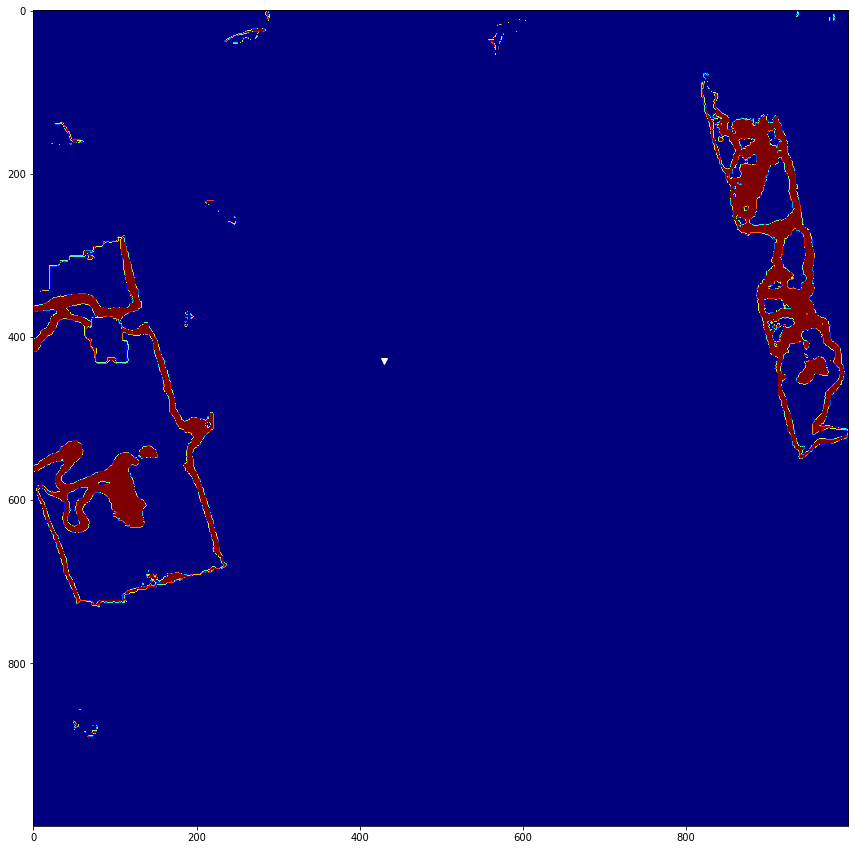

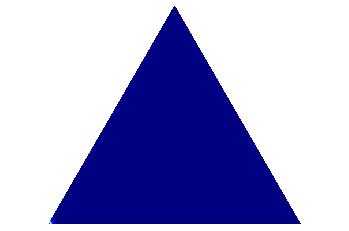

In [ ]:
# lims = dataset.previewLims1
lims = dataset.previewLims2

# im = manager.alpha_unpad[lims[0]:lims[1], lims[2]:lims[3]]
im = manager.uncertainty_map[lims[0]:lims[1], lims[2]:lims[3]]
plt.figure(figsize=(15,15))
plt.imshow(im.astype(np.uint8), cmap='jet')

# row, col = (550, 550) # high evidence in class 0
# row, col = (200, 600) # class 1 is higher but it has high uncertainty
# row, col = (207, 617) # class 1 is higher but it has high uncertainty
row, col = (800, 200) # high evidence in class 1
# row, col = (200, 605) # alpha 1, 1, 1

row, col = (430, 950) # alpha 1, 1, 1
row, col = (430, 430) # alpha 1, 1, 1

plt.plot(col, row, marker='v', color="white")

plt.figure()
print("Reference",manager.label_mask[lims[0]:lims[1], lims[2]:lims[3]][row, col])
print("Predicted",manager.predicted_unpad[lims[0]:lims[1], lims[2]:lims[3]][row, col])
print("Evidence", manager.alpha_unpad[lims[0]:lims[1], lims[2]:lims[3]][row, col] - 1)
print("Alpha", manager.alpha_unpad[lims[0]:lims[1], lims[2]:lims[3]][row, col])

manager.getMassFcn(manager.alpha_unpad[lims[0]:lims[1], lims[2]:lims[3]][row, col])


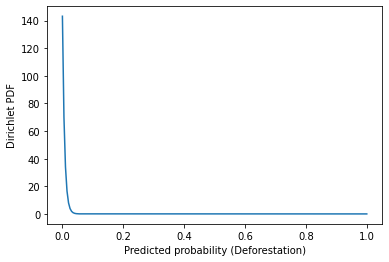

In [ ]:
manager.getMassFcn2D(manager.alpha_unpad[lims[0]:lims[1], lims[2]:lims[3]][row, col][:2])


In [ ]:

if config['dataset'] == 'PA':
    manager.getPOIValues()


[{'snippet_id': 0,
  'coords': [550, 550],
  'reference': 0,
  'predicted': 0.0,
  'alpha': array([136.90787,   1.     ,   1.     ], dtype=float32)},
 {'snippet_id': 0,
  'coords': [210, 610],
  'reference': 1,
  'predicted': 0.0,
  'alpha': array([1., 1., 1.], dtype=float32)},
 {'snippet_id': 0,
  'coords': [207, 617],
  'reference': 1,
  'predicted': 0.0,
  'alpha': array([1., 1., 1.], dtype=float32)},
 {'snippet_id': 0,
  'coords': [800, 200],
  'reference': 1,
  'predicted': 1.0,
  'alpha': array([1.     , 5.56545, 1.     ], dtype=float32)},
 {'snippet_id': 1,
  'coords': [550, 115],
  'reference': 1,
  'predicted': 0.0,
  'alpha': array([1., 1., 1.], dtype=float32)},
 {'snippet_id': 1,
  'coords': [430, 950],
  'reference': 0,
  'predicted': 0.0,
  'alpha': array([1., 1., 1.], dtype=float32)}]

In [ ]:
'''
lims = dataset.previewLims1

coords = {
    "snippet_id0": [
        [550, 550], # 10,1 alpha
        [210, 610], #harder 1,1 alpha
        [207, 617], # easy 1,1 alpha
        [800, 200] # easy 1,10 alpha
    ],
    "snippet_id1": [
        [550, 115], # 10,1 alpha # I think will diverge from ensemble
        [430, 950] # Will diverge from ensemble
    ]
}

poi_alpha_info = []
for coord in coords["snippet_id0"]:
    poi_alpha_info.append(
        {"snippet_id": 0,
            "coords": coord, # 10,1 alpha
               "reference": manager.label_mask[lims[0]:lims[1], lims[2]:lims[3]][coord[0], coord[1]],
               "predicted": manager.predicted_unpad[lims[0]:lims[1], lims[2]:lims[3]][coord[0], coord[1]],
               "alpha": manager.alpha_unpad[lims[0]:lims[1], lims[2]:lims[3]][coord[0], coord[1]]}
    )

poi_alpha_info
lims = dataset.previewLims2

poi_alpha_info2 = []
for coord in coords["snippet_id1"]:
    poi_alpha_info2.append(
        {"snippet_id": 1,
            "coords": coord, # 10,1 alpha
               "reference": manager.label_mask[lims[0]:lims[1], lims[2]:lims[3]][coord[0], coord[1]],
               "predicted": manager.predicted_unpad[lims[0]:lims[1], lims[2]:lims[3]][coord[0], coord[1]],
               "alpha": manager.alpha_unpad[lims[0]:lims[1], lims[2]:lims[3]][coord[0], coord[1]]}
    )

poi_alpha_info.extend(poi_alpha_info2)
'''

'\nlims = dataset.previewLims1\n\ncoords = {\n    "snippet_id0": [\n        [550, 550], # 10,1 alpha\n        [210, 610], #harder 1,1 alpha\n        [207, 617], # easy 1,1 alpha\n        [800, 200] # easy 1,10 alpha\n    ],\n    "snippet_id1": [\n        [550, 115], # 10,1 alpha # I think will diverge from ensemble\n        [430, 950] # Will diverge from ensemble\n    ]\n}\n\npoi_alpha_info = []\nfor coord in coords["snippet_id0"]:\n    poi_alpha_info.append(\n        {"snippet_id": 0,\n            "coords": coord, # 10,1 alpha\n               "reference": trainer.label_mask[lims[0]:lims[1], lims[2]:lims[3]][coord[0], coord[1]],\n               "predicted": trainer.predicted_unpad[lims[0]:lims[1], lims[2]:lims[3]][coord[0], coord[1]],\n               "alpha": trainer.alpha_unpad[lims[0]:lims[1], lims[2]:lims[3]][coord[0], coord[1]]}\n    )\n\npoi_alpha_info\nlims = dataset.previewLims2\n\npoi_alpha_info2 = []\nfor coord in coords["snippet_id1"]:\n    poi_alpha_info2.append(\n        {"

In [ ]:
# manager.getMassFcn(manager.alpha_reconstructed[2500,7300])
# manager.getMassFcn(manager.alpha_unpad[16500,6600])


In [ ]:
# manager.m

In [ ]:
'''
from src import metrics as _metrics
def getUncertaintyAAValues(self):



    # self.threshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]

    # self.threshold_list = [0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003]
    if self.config['uncertainty_method'] == "pred_entropy":
            if self.classes_mode == False:
                self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                        0.25, 0.27, 0.3, 0.34, 0.36, np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]
            else:
                self.threshold_list = [0.0025, 0.025, 0.05, 0.1, 0.2, 0.4, 
                    0.5, 0.6, 0.7, 0.8, 0.9, np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]
                # self.threshold_list = [0.13, 0.15, 0.2, 0.225, 
                #     0.25, 0.27, 0.3, 0.34, 0.36, 0.45, 0.55, 0.65, 0.8]
    elif self.config['uncertainty_method'] == "pred_var":
            self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [x*0.13/0.36 for x in self.threshold_list] + [np.max(self.uncertainty)-0.0015, np.max(self.uncertainty)-0.0008]
    elif self.config['uncertainty_method'] == "MI":
            self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [x*0.235/0.36 for x in self.threshold_list] + [np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]
    elif self.config['uncertainty_method'] == "KL":
            self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [x*1.0/0.36 for x in self.threshold_list] + [np.max(self.uncertainty)-0.006, np.max(self.uncertainty)-0.003]
    elif self.config['uncertainty_method'] == "evidential":
            # self.threshold_list = [0.015, 0.03, 0.04]
            self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [ 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [ 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36, 0.45, 0.55, 0.65, 0.8]

            self.threshold_list = [0.13, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36, 0.45, 0.55, 0.65, 0.8]
            self.threshold_list = [0.025, 0.05, 0.075, 0.09, 0.1, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.35, 0.45, 0.55, 0.65, 0.8, 0.9, 0.95, 0.99]

            # self.threshold_list = [ 0.15, 0.2,  
            #          0.3, 0.35, 0.4, 0.5, 0.6, 0.7]

            # self.threshold_list = [0.015,0.1, 0.2, 0.27, 0.36, 0.45, 0.55, 0.65]

            # self.threshold_list = [x*1.0/0.36 for x in self.threshold_list] + [np.max(uncertainty)-0.006, np.max(uncertainty)-0.003]
                    
            # self.threshold_list = np.linspace(np.min(uncertainty) + 0.0015, np.max(uncertainty) - 0.0015, 19)
    print(self.threshold_list)
    self.loadThresholdMetrics = False
    if self.loadThresholdMetrics == False:
            # self.threshold_list = [0.1]
            # y_test
            ic(self.uncertainty.shape, self.label_mask_current_deforestation_test.shape)

            metrics_values = _metrics.getAA_Recall(self.uncertainty, 
                    self.label_mask_current_deforestation_test, 
                    self.predicted_test, self.threshold_list)

            # ic(metrics_values)


    self.m = {'precision_L': metrics_values[:,0],
            'recall_L': metrics_values[:,1],
            'recall_Ltotal': metrics_values[:,2],
            'AA': metrics_values[:,3],
            'precision_H': metrics_values[:,4],
            'recall_H': metrics_values[:,5],
            'UEO': metrics_values[:,6]}

    self.m['f1_L'] = 2*self.m['precision_L']*self.m['recall_L']/(self.m['precision_L']+self.m['recall_L'])
    self.m['f1_H'] = 2*self.m['precision_H']*self.m['recall_H']/(self.m['precision_H']+self.m['recall_H'])
'''

In [ ]:
'''
import types

manager.getUncertaintyAAValues = types.MethodType(getUncertaintyAAValues, manager)
'''


In [ ]:
manager.getUncertaintyAAValues()

ic| self.uncertainty.shape: (54102424,)
    self.label_mask_current_deforestation_test.shape: (54102424,)


[0.025, 0.05, 0.075, 0.09, 0.1, 0.15, 0.2, 0.225, 0.25, 0.27, 0.3, 0.35, 0.45, 0.55, 0.65, 0.8, 0.9, 0.95, 0.99]
threshold 0.025


ic| label_current_deforestation_test_classified_incorrect.shape: (13562900,)
    predicted_test_classified_incorrect.shape: (13562900,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:293: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_L = TP_L / (TP_L + FP_L)
ic| TP_H + FN_H + FP_H + TN_H: 13562900
    len(label_mask_current_deforestation_test): 54102424
ic| TP_H + FN_H + FP_H + TN_H: 13562900
    len(label_mask_current_deforestation_test): 54102424


[       nan 0.         0.         0.25068932 0.88604967 0.71122807
 0.02041978]
threshold 0.05


ic| label_current_deforestation_test_classified_incorrect.shape: (6923149,)
    predicted_test_classified_incorrect.shape: (6923149,)
ic| TP_H + FN_H + FP_H + TN_H: 6923149
    len(label_mask_current_deforestation_test): 54102424
ic| TP_H + FN_H + FP_H + TN_H: 6923149
    len(label_mask_current_deforestation_test): 54102424


[1.00000000e+00 9.63232703e-03 1.12227148e-04 1.27963749e-01
 8.86033688e-01 7.17348798e-01 3.90600700e-02]
threshold 0.075


ic| label_current_deforestation_test_classified_incorrect.shape: (5537916,)
    predicted_test_classified_incorrect.shape: (5537916,)
ic| TP_H + FN_H + FP_H + TN_H: 5537916
    len(label_mask_current_deforestation_test): 54102424
ic| TP_H + FN_H + FP_H + TN_H: 5537916
    len(label_mask_current_deforestation_test): 54102424


[1.         0.31853117 0.00765745 0.10235985 0.88494883 0.71872371
 0.04814675]
threshold 0.09


ic| label_current_deforestation_test_classified_incorrect.shape: (5057014,)
    predicted_test_classified_incorrect.shape: (5057014,)
ic| TP_H + FN_H + FP_H + TN_H: 5057014
    len(label_mask_current_deforestation_test): 54102424
ic| TP_H + FN_H + FP_H + TN_H: 5057014
    len(label_mask_current_deforestation_test): 54102424


[0.99713526 0.64182604 0.03334652 0.09347112 0.88120526 0.71279012
 0.0523622 ]
threshold 0.1


ic| label_current_deforestation_test_classified_incorrect.shape: (4799576,)
    predicted_test_classified_incorrect.shape: (4799576,)
ic| TP_H + FN_H + FP_H + TN_H: 4799576
    len(label_mask_current_deforestation_test): 54102424
ic| TP_H + FN_H + FP_H + TN_H: 4799576
    len(label_mask_current_deforestation_test): 54102424


[0.99623089 0.76809826 0.06547633 0.08871277 0.87619149 0.70360546
 0.05495284]
threshold 0.15


ic| label_current_deforestation_test_classified_incorrect.shape: (3869332,)
    predicted_test_classified_incorrect.shape: (3869332,)
ic| TP_H + FN_H + FP_H + TN_H: 3869332
    len(label_mask_current_deforestation_test): 54102424
ic| TP_H + FN_H + FP_H + TN_H: 3869332
    len(label_mask_current_deforestation_test): 54102424


[0.9904151  0.91397493 0.26035603 0.07151864 0.83500011 0.62749654
 0.0667081 ]
threshold 0.2


ic| label_current_deforestation_test_classified_incorrect.shape: (3272003,)
    predicted_test_classified_incorrect.shape: (3272003,)
ic| TP_H + FN_H + FP_H + TN_H: 3272003
    len(label_mask_current_deforestation_test): 54102424
ic| TP_H + FN_H + FP_H + TN_H: 3272003
    len(label_mask_current_deforestation_test): 54102424


[0.97875653 0.92760398 0.36743305 0.06047794 0.80413915 0.56578181
 0.07651276]
threshold 0.225


ic| label_current_deforestation_test_classified_incorrect.shape: (3038472,)
    predicted_test_classified_incorrect.shape: (3038472,)
ic| TP_H + FN_H + FP_H + TN_H: 3038472
    len(label_mask_current_deforestation_test): 54102424
ic| TP_H + FN_H + FP_H + TN_H: 3038472
    len(label_mask_current_deforestation_test): 54102424


[0.97214702 0.92956032 0.40350313 0.05616148 0.79328537 0.54000522
 0.08092863]
threshold 0.25


ic| label_current_deforestation_test_classified_incorrect.shape: (2830338,)
    predicted_test_classified_incorrect.shape: (2830338,)
ic| TP_H + FN_H + FP_H + TN_H: 2830338
    len(label_mask_current_deforestation_test): 54102424
ic| TP_H + FN_H + FP_H + TN_H: 2830338
    len(label_mask_current_deforestation_test): 54102424


[0.96552639 0.9304742  0.43349652 0.05231444 0.78448215 0.51600876
 0.08522731]
threshold 0.27


ic| label_current_deforestation_test_classified_incorrect.shape: (2680625,)
    predicted_test_classified_incorrect.shape: (2680625,)
ic| TP_H + FN_H + FP_H + TN_H: 2680625
    len(label_mask_current_deforestation_test): 54102424
ic| TP_H + FN_H + FP_H + TN_H: 2680625
    len(label_mask_current_deforestation_test): 54102424


[0.96061747 0.93113257 0.45471566 0.04954723 0.77808709 0.49718734
 0.08863591]
threshold 0.3


ic| label_current_deforestation_test_classified_incorrect.shape: (2477459,)
    predicted_test_classified_incorrect.shape: (2477459,)
ic| TP_H + FN_H + FP_H + TN_H: 2477459
    len(label_mask_current_deforestation_test): 54102424
ic| TP_H + FN_H + FP_H + TN_H: 2477459
    len(label_mask_current_deforestation_test): 54102424


[0.95399105 0.93214941 0.48311187 0.04579201 0.76897607 0.46913142
 0.09382714]
threshold 0.35


ic| label_current_deforestation_test_classified_incorrect.shape: (2189529,)
    predicted_test_classified_incorrect.shape: (2189529,)
ic| TP_H + FN_H + FP_H + TN_H: 2189529
    len(label_mask_current_deforestation_test): 54102424
ic| TP_H + FN_H + FP_H + TN_H: 2189529
    len(label_mask_current_deforestation_test): 54102424


[0.94408596 0.93265826 0.5226254  0.04047007 0.75583021 0.42416111
 0.10224104]
threshold 0.45


ic| label_current_deforestation_test_classified_incorrect.shape: (1755488,)
    predicted_test_classified_incorrect.shape: (1755488,)
ic| TP_H + FN_H + FP_H + TN_H: 1755488
    len(label_mask_current_deforestation_test): 54102424
ic| TP_H + FN_H + FP_H + TN_H: 1755488
    len(label_mask_current_deforestation_test): 54102424


[0.92801752 0.93271231 0.58061536 0.03244749 0.73570415 0.34036683
 0.11856411]
threshold 0.55


ic| label_current_deforestation_test_classified_incorrect.shape: (1412785,)
    predicted_test_classified_incorrect.shape: (1412785,)
ic| TP_H + FN_H + FP_H + TN_H: 1412785
    len(label_mask_current_deforestation_test): 54102424
ic| TP_H + FN_H + FP_H + TN_H: 1412785
    len(label_mask_current_deforestation_test): 54102424


[0.91485995 0.93153667 0.62435794 0.02611316 0.71918882 0.25699451
 0.13648601]
threshold 0.65


ic| label_current_deforestation_test_classified_incorrect.shape: (1081613,)
    predicted_test_classified_incorrect.shape: (1081613,)
ic| TP_H + FN_H + FP_H + TN_H: 1081613
    len(label_mask_current_deforestation_test): 54102424
ic| TP_H + FN_H + FP_H + TN_H: 1081613
    len(label_mask_current_deforestation_test): 54102424


[0.90055503 0.92955357 0.66441756 0.01999195 0.71484871 0.15666536
 0.16107344]
threshold 0.8


ic| label_current_deforestation_test_classified_incorrect.shape: (706084,)
    predicted_test_classified_incorrect.shape: (706084,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:296: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 706084
    len(label_mask_current_deforestation_test): 54102424
ic| TP_H + FN_H + FP_H + TN_H: 706084
    len(label_mask_current_deforestation_test): 54102424


[0.88604967 0.89144027 0.70910313 0.01305088        nan 0.
 0.17880935]
threshold 0.9


ic| label_current_deforestation_test_classified_incorrect.shape: (499578,)
    predicted_test_classified_incorrect.shape: (499578,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:296: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 499578
    len(label_mask_current_deforestation_test): 54102424
ic| TP_H + FN_H + FP_H + TN_H: 499578
    len(label_mask_current_deforestation_test): 54102424


[0.88604967 0.83769713 0.70910313 0.00923393        nan 0.
 0.16826284]
threshold 0.95


ic| label_current_deforestation_test_classified_incorrect.shape: (412035,)
    predicted_test_classified_incorrect.shape: (412035,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:296: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 412035
    len(label_mask_current_deforestation_test): 54102424
ic| TP_H + FN_H + FP_H + TN_H: 412035
    len(label_mask_current_deforestation_test): 54102424


[0.88604967 0.81685891 0.70910313 0.00761583        nan 0.
 0.16203817]
threshold 0.99


ic| label_current_deforestation_test_classified_incorrect.shape: (349179,)
    predicted_test_classified_incorrect.shape: (349179,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:296: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 349179
    len(label_mask_current_deforestation_test): 54102424
ic| TP_H + FN_H + FP_H + TN_H: 349179
    len(label_mask_current_deforestation_test): 54102424


[0.88604967 0.80286426 0.70910313 0.00645404        nan 0.
 0.15713525]


In [ ]:
manager.getUncertaintyAAAuditedValues()

ic| self.uncertainty.shape: (54102424,)
    self.label_mask_current_deforestation_test.shape: (54102424,)


threshold 0.025
(54102424,) (54102424,)
cm_audited [[53371763        0]
 [    2183   728478]]
[1.         0.99701229]
threshold 0.05
(54102424,) (54102424,)
cm_audited [[53371763        0]
 [    8431   722230]]
[1.         0.98846113]
threshold 0.075
(54102424,) (54102424,)
cm_audited [[53371763        0]
 [   11970   718691]]
[1.         0.98361757]
threshold 0.09
(54102424,) (54102424,)
cm_audited [[53371693       70]
 [   13597   717064]]
[0.99990239 0.98139082]
threshold 0.1
(54102424,) (54102424,)
cm_audited [[53371582      181]
 [   14444   716217]]
[0.99974735 0.9802316 ]
threshold 0.15
(54102424,) (54102424,)
cm_audited [[53369922     1841]
 [   17905   712756]]
[0.99742372 0.97549479]
threshold 0.2
(54102424,) (54102424,)
cm_audited [[53365936     5827]
 [   20953   709708]]
[0.99185644 0.97132323]
threshold 0.225
(54102424,) (54102424,)
cm_audited [[53363316     8447]
 [   22341   708320]]
[0.98821514 0.96942358]
threshold 0.25
(54102424,) (54102424,)
cm_audited [[53360454   

ic| metric_values_audited: array([[1.        , 0.99701229],
                                  [1.        , 0.98846113],
                                  [1.        , 0.98361757],
                                  [0.99990239, 0.98139082],
                                  [0.99974735, 0.9802316 ],
                                  [0.99742372, 0.97549479],
                                  [0.99185644, 0.97132323],
                                  [0.98821514, 0.96942358],
                                  [0.98425595, 0.96760878],
                                  [0.9810743 , 0.96636881],
                                  [0.97642076, 0.96483458],
                                  [0.96883582, 0.96226431],
                                  [0.95510545, 0.95811327],
                                  [0.94259642, 0.95411278],
                                  [0.9282815 , 0.94964696],
                                  [0.90924507, 0.91364532],
                                  [0.904

cm_audited [[53305131    66632]
 [  127218   603443]]
[0.90056039 0.82588642]


In [ ]:
manager.setPlotLimsForUncertaintyAA()

In [ ]:

def plotUncertaintyAA(self):

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_figheight(5)
    fig.set_figwidth(15)
    ax1.plot(self.m['AA']*100, self.m['precision_L']*100, 'C3-', label="Precision Low Uncertainty")
    ax1.plot(self.m['AA']*100, self.m['recall_L']*100, 'C3--', label="Recall Low Uncertainty")
    ax1.plot(self.m['AA']*100, self.m['precision_H']*100, 'C0-', label="Precision High Uncertainty")
    ax1.plot(self.m['AA']*100, self.m['recall_H']*100, 'C0--', label="Recall High Uncertainty")
    ax1.plot(self.m['AA']*100, self.m_audited['precision']*100, 'C2-', label="Precision Audited")
    ax1.plot(self.m['AA']*100, self.m_audited['recall']*100, 'C2--', label="Recall Audited")

    ax1.legend(loc="lower right")
    ax1.set_ylabel('Precision/recall (%)')
    ax1.set_xlabel('Audit Area (%)')
    ax1.set_ylim(self.ylim)
    ax1.set_xlim(self.xlim)
    ax1.grid()

    xs = [0, 120]
    ax1.vlines(x = 3, ymin = 0, ymax = max(xs),
            colors = (0.2, 0.2, 0.2),
            label = 'vline_multiple - full height')

    ax2.plot(range(int(self.xlim[0]), int(self.xlim[1] + 2)), 
        np.ones(int(self.xlim[1] + 2)) * self.f1, 
        'C1:', label="F1 No Uncertainty")

    ax2.plot(self.m['AA']*100, self.m['f1_L']*100, 'C3-', label="F1 Low Uncertainty")
    ax2.plot(self.m['AA']*100, self.m['f1_H']*100, 'C0-', label="F1 High Uncertainty")
    ax2.plot(self.m['AA']*100, self.m_audited['f1']*100, 'C2-', label="F1 Audited")

    ax2.legend(loc="lower right")
    ax2.set_ylabel('F1 score (%)')
    ax2.set_xlabel('Audit Area (%)')
    ax2.set_ylim(self.ylim)
    ax2.set_xlim(self.xlim)

    ax2.grid()

    xs = [0, 120]
    ax2.vlines(x = 3, ymin = 0, ymax = max(xs),
            colors = (0.2, 0.2, 0.2),
            label = '3% AA')

    ax3.plot(np.asarray(self.threshold_list), self.m['AA']*100, label="AA")
    ax3.set_ylabel('Audit Area (%)')
    ax3.set_xlabel('Uncertainty Threshold')
    ax3.grid()
    ax3.set_ylim(self.xlim)

    self.xlim_adjusted = ax3.get_xlim()
    ax3.hlines(y = 3, xmin = self.xlim_adjusted[0], xmax = self.xlim_adjusted[1],
            colors = (0.2, 0.2, 0.2),
            label = '3% AA')

    ax3.set_xlim(self.xlim_adjusted)

    # if save_figures == True:
    if True:
        plt.savefig('output/figures/recall_precision_f1_AA.png', dpi=150, bbox_inches='tight')

def plotUEO(self): 

    plt.plot(self.m['AA']*100, self.m['UEO'], label="UEO") 
    plt.grid() 
    plt.xlabel('Audit Area (%)') 
    plt.ylabel('UEO (%)') 
    plt.xlim(self.xlim)
    plt.ylim([0, 0.4])

import types

manager.plotUncertaintyAA = types.MethodType(plotUncertaintyAA, manager)
manager.plotUEO = types.MethodType(plotUEO, manager)


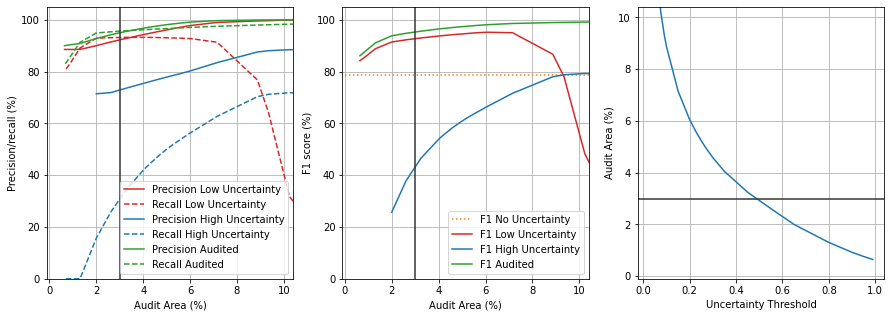

In [ ]:
manager.plotUncertaintyAA()

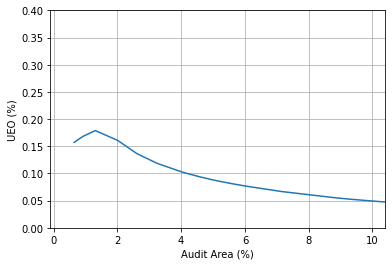

In [ ]:
manager.plotUEO()

In [ ]:
manager.getOptimalUncertaintyThreshold()

ic| bounds: (0.0015, 0.9985)
c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


0.38232011321635484
threshold 0.38232011321635484


ic| label_current_deforestation_test_classified_incorrect.shape: (2033069,)
    predicted_test_classified_incorrect.shape: (2033069,)
ic| TP_H + FN_H + FP_H + TN_H: 2033069
    len(label_mask_current_deforestation_test): 54102424
ic| TP_H + FN_H + FP_H + TN_H: 2033069
    len(label_mask_current_deforestation_test): 54102424


[0.93816898 0.93289751 0.54353661 0.03757815 0.74937899 0.39669262
 0.10749978]
0.6176798867836452
threshold 0.6176798867836452


ic| label_current_deforestation_test_classified_incorrect.shape: (1183520,)
    predicted_test_classified_incorrect.shape: (1183520,)
ic| TP_H + FN_H + FP_H + TN_H: 1183520
    len(label_mask_current_deforestation_test): 54102424
ic| TP_H + FN_H + FP_H + TN_H: 1183520
    len(label_mask_current_deforestation_test): 54102424


[0.90545798 0.93029069 0.65142795 0.02187554 0.71334744 0.19240533
 0.15274446]
0.23685977356729035
threshold 0.23685977356729035


ic| label_current_deforestation_test_classified_incorrect.shape: (2936877,)
    predicted_test_classified_incorrect.shape: (2936877,)
ic| TP_H + FN_H + FP_H + TN_H: 2936877
    len(label_mask_current_deforestation_test): 54102424
ic| TP_H + FN_H + FP_H + TN_H: 2936877
    len(label_mask_current_deforestation_test): 54102424


[0.96896405 0.92997428 0.41819257 0.05428365 0.78899563 0.52862252
 0.08296674]
0.49622785679192494
threshold 0.49622785679192494


ic| label_current_deforestation_test_classified_incorrect.shape: (1592727,)
    predicted_test_classified_incorrect.shape: (1592727,)
ic| TP_H + FN_H + FP_H + TN_H: 1592727
    len(label_mask_current_deforestation_test): 54102424
ic| TP_H + FN_H + FP_H + TN_H: 1592727
    len(label_mask_current_deforestation_test): 54102424


[0.9216641  0.93232568 0.6018345  0.02943911 0.72818069 0.30260806
 0.126283  ]
0.4977950374501111
threshold 0.4977950374501111


ic| label_current_deforestation_test_classified_incorrect.shape: (1587465,)
    predicted_test_classified_incorrect.shape: (1587465,)
ic| TP_H + FN_H + FP_H + TN_H: 1587465
    len(label_mask_current_deforestation_test): 54102424
ic| TP_H + FN_H + FP_H + TN_H: 1587465
    len(label_mask_current_deforestation_test): 54102424


[0.92145051 0.93230673 0.60248323 0.02934185 0.72800419 0.30138073
 0.12655149]
0.46803632747768253
threshold 0.46803632747768253


ic| label_current_deforestation_test_classified_incorrect.shape: (1689644,)
    predicted_test_classified_incorrect.shape: (1689644,)
ic| TP_H + FN_H + FP_H + TN_H: 1689644
    len(label_mask_current_deforestation_test): 54102424
ic| TP_H + FN_H + FP_H + TN_H: 1689644
    len(label_mask_current_deforestation_test): 54102424


[0.92537471 0.93259829 0.58912546 0.03123047 0.73307856 0.32576366
 0.12153803]
0.48545965078872333
threshold 0.48545965078872333


ic| label_current_deforestation_test_classified_incorrect.shape: (1629327,)
    predicted_test_classified_incorrect.shape: (1629327,)
ic| TP_H + FN_H + FP_H + TN_H: 1629327
    len(label_mask_current_deforestation_test): 54102424
ic| TP_H + FN_H + FP_H + TN_H: 1629327
    len(label_mask_current_deforestation_test): 54102424


[0.92305007 0.93241605 0.59701421 0.0301156  0.73015887 0.31160683
 0.12442983]
0.4785271845547386
threshold 0.4785271845547386


ic| label_current_deforestation_test_classified_incorrect.shape: (1653160,)
    predicted_test_classified_incorrect.shape: (1653160,)
ic| TP_H + FN_H + FP_H + TN_H: 1653160
    len(label_mask_current_deforestation_test): 54102424
ic| TP_H + FN_H + FP_H + TN_H: 1653160
    len(label_mask_current_deforestation_test): 54102424


[0.92400446 0.93251862 0.59392112 0.03055612 0.73118158 0.31721843
 0.12328703]
0.48735475125940236
threshold 0.48735475125940236


ic| label_current_deforestation_test_classified_incorrect.shape: (1622777,)
    predicted_test_classified_incorrect.shape: (1622777,)
ic| TP_H + FN_H + FP_H + TN_H: 1622777
    len(label_mask_current_deforestation_test): 54102424
ic| TP_H + FN_H + FP_H + TN_H: 1622777
    len(label_mask_current_deforestation_test): 54102424


[0.92280035 0.93237855 0.59786686 0.02999453 0.72982948 0.31004688
 0.12474956]
0.49074397598706126
threshold 0.49074397598706126


ic| label_current_deforestation_test_classified_incorrect.shape: (1611358,)
    predicted_test_classified_incorrect.shape: (1611358,)
ic| TP_H + FN_H + FP_H + TN_H: 1611358
    len(label_mask_current_deforestation_test): 54102424
ic| TP_H + FN_H + FP_H + TN_H: 1611358
    len(label_mask_current_deforestation_test): 54102424


[0.92231086 0.9323698  0.59940656 0.02978347 0.72936155 0.30717434
 0.12530826]
0.48768264362685876
threshold 0.48768264362685876


ic| label_current_deforestation_test_classified_incorrect.shape: (1621690,)
    predicted_test_classified_incorrect.shape: (1621690,)
ic| TP_H + FN_H + FP_H + TN_H: 1621690
    len(label_mask_current_deforestation_test): 54102424
ic| TP_H + FN_H + FP_H + TN_H: 1621690
    len(label_mask_current_deforestation_test): 54102424


[0.92274748 0.93237395 0.59801194 0.02997444 0.72980822 0.3097796
 0.12479918]
0.48694824354176974
threshold 0.48694824354176974


ic| label_current_deforestation_test_classified_incorrect.shape: (1624218,)
    predicted_test_classified_incorrect.shape: (1624218,)
ic| TP_H + FN_H + FP_H + TN_H: 1624218
    len(label_mask_current_deforestation_test): 54102424
ic| TP_H + FN_H + FP_H + TN_H: 1624218
    len(label_mask_current_deforestation_test): 54102424


[0.92286187 0.93239409 0.59771221 0.03002117 0.72983491 0.31032524
 0.12468122]
0.4872934787818929
threshold 0.4872934787818929


ic| label_current_deforestation_test_classified_incorrect.shape: (1623004,)
    predicted_test_classified_incorrect.shape: (1623004,)
ic| TP_H + FN_H + FP_H + TN_H: 1623004
    len(label_mask_current_deforestation_test): 54102424
ic| TP_H + FN_H + FP_H + TN_H: 1623004
    len(label_mask_current_deforestation_test): 54102424


[0.92282504 0.9323842  0.59784497 0.02999873 0.72977656 0.31008426
 0.12474478]
0.4872137535562624
threshold 0.4872137535562624


ic| label_current_deforestation_test_classified_incorrect.shape: (1623284,)
    predicted_test_classified_incorrect.shape: (1623284,)
ic| TP_H + FN_H + FP_H + TN_H: 1623284
    len(label_mask_current_deforestation_test): 54102424
ic| TP_H + FN_H + FP_H + TN_H: 1623284
    len(label_mask_current_deforestation_test): 54102424


[0.92283136 0.93238714 0.59781622 0.03000391 0.72979474 0.31013597
 0.12472945]
0.48726013822082925
threshold 0.48726013822082925


ic| label_current_deforestation_test_classified_incorrect.shape: (1623127,)
    predicted_test_classified_incorrect.shape: (1623127,)
ic| TP_H + FN_H + FP_H + TN_H: 1623127
    len(label_mask_current_deforestation_test): 54102424
ic| TP_H + FN_H + FP_H + TN_H: 1623127
    len(label_mask_current_deforestation_test): 54102424
ic| self.threshold_optimal: 0.48726013822082925


[0.92282698 0.93238645 0.59782854 0.030001   0.72979256 0.31011347
 0.12473837]


In [ ]:
snapshot = tracemalloc.take_snapshot()
display_top(snapshot, limit=20)

Top 20 lines
#1: ipykernel_12372\3510209264.py:3: 13380609.6 KiB
    trainer.image_stack = trainer.image_stack[..., trainer.patchesHandler.dataset.image_channels[-1]]
#2: src\patchesHandler.py:341: 1918080.1 KiB
    alpha_reconstructed = np.zeros((h, w, 3), dtype=np.float32)
#3: deforestation_uncertainty\utils_v1.py:416: 760431.1 KiB
    return vector_test[label_mask_test != 2]
#4: trainer\base.py:361: 639360.2 KiB
    self.uncertainty_to_show = self.uncertainty_map.copy()[:self.label_mask.shape[0], :self.label_mask.shape[1]]
#5: trainer\evidential.py:533: 639360.1 KiB
    self.prob_rec = prob_reconstructed.copy()
#6: src\patchesHandler.py:340: 639360.1 KiB
    u_reconstructed = np.zeros((h, w), dtype=np.float32)
#7: trainer\evidential.py:554: 637172.0 KiB
    self.predicted_unpad = self.predicted.copy()
#8: trainer\base.py:494: 637172.0 KiB
    self.error_mask = np.abs(self.predicted_unpad - self.label_mask_current_deforestation)
#9: trainer\base.py:332: 637172.0 KiB
    self.mean_pro

In [ ]:
manager.getUncertaintyMetricsFromOptimalThreshold()

threshold 0.48726013822082925


ic| label_current_deforestation_test_classified_incorrect.shape: (1623127,)
    predicted_test_classified_incorrect.shape: (1623127,)
ic| TP_H + FN_H + FP_H + TN_H: 1623127
    len(label_mask_current_deforestation_test): 54102424
ic| TP_H + FN_H + FP_H + TN_H: 1623127
    len(label_mask_current_deforestation_test): 54102424


[0.92282698 0.93238645 0.59782854 0.030001   0.72979256 0.31011347
 0.12473837]
threshold 0.48726013822082925
(54102424,) (54102424,)


ic| self.m_optimal: {'AA': array([0.030001]),
                     'UEO': array([0.12473837]),
                     'f1': 78.78,
                     'f1_H': array([0.43526722]),
                     'f1_L': array([0.92758209]),
                     'precision_H': array([0.72979256]),
                     'precision_L': array([0.92282698]),
                     'recall_H': array([0.31011347]),
                     'recall_L': array([0.93238645]),
                     'recall_Ltotal': array([0.59782854])}
ic| self.m_audited_optimal: {'f1': array([0.953481]),
                             'precision': array([0.95033541]),
                             'recall': array([0.95664747])}


cm_audited [[53335234    36529]
 [   31676   698985]]
[0.95033541 0.95664747]


{'metrics': {'precision_L': array([0.92282698]),
  'recall_L': array([0.93238645]),
  'recall_Ltotal': array([0.59782854]),
  'AA': array([0.030001]),
  'precision_H': array([0.72979256]),
  'recall_H': array([0.31011347]),
  'UEO': array([0.12473837]),
  'f1_L': array([0.92758209]),
  'f1_H': array([0.43526722]),
  'f1': 78.78},
 'metrics_audited': {'precision': array([0.95033541]),
  'recall': array([0.95664747]),
  'f1': array([0.953481])},
 'exp': 195}